In [1]:
!pip install biopython
%pip install Bio ete3
!pip install cus
!apt-get install clustalw


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 24.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 10.0 MB/s eta 0:00:00
  Created wheel for ete3: filename=ete3-3.1.3-py3-none-any.whl size=2273788 sha256=ed4dcef5b03506907c8248297dcd51ecfaee66b570fa0dbb13f4338b7eb00efc
  Stored in directory: /root/.cache/pip/wheels/a0/72/00/1982bd848e52b03079dbf800900120bc1c20e92e9a1216e525
Successfully built ete3
ERROR: Could not find a version that satisfies the requirement cus (from versions: none)
ERROR: No matching distribution found for cus
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  clustalx seaview
The following NEW packages will be installed:
  clustalw
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 275 kB of archives.
After this operatio

Differences from root sequence to each leaf sequence:
[132, 131, 132, 132, 132, 129, 130, 141, 130, 139, 133, 135, 136, 129, 125, 129, 131, 137, 140, 140, 149, 157, 141, 159, 146, 151, 147, 141, 152, 147, 141, 150]
Average differences: 138.875
Number of remaining leaves after deletion: 22


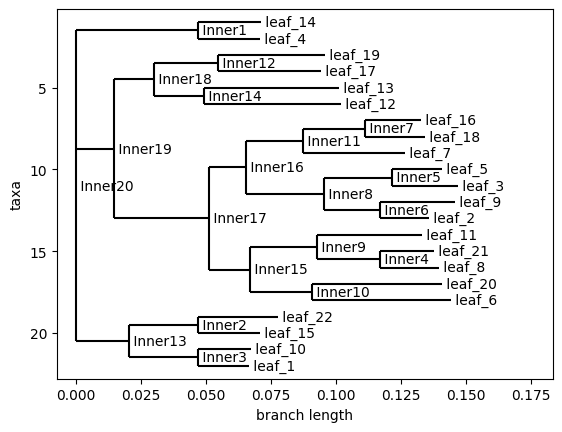

RF distance between full tree and subtree 0: 0, Normalized RF: 0.0
RF distance between full tree and subtree 1: 0, Normalized RF: 0.0
RF distance between full tree and subtree 2: 0, Normalized RF: 0.0
RF distance between subtree 0 and subtree 1: 0, Normalized RF: 0.0
RF distance between subtree 0 and subtree 2: 0, Normalized RF: 0.0
RF distance between subtree 1 and subtree 2: 0, Normalized RF: 0.0
Phylogenetic tree construction and comparison complete.


In [3]:
import random
import os
from Bio import Phylo, AlignIO, SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align.Applications import ClustalwCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from ete3 import Tree
import numpy as np

# Parameters
p = 0.01
exon_length = 900
non_coding_length = 300

# Function to generate a random DNA sequence of a given length
def generate_dna_sequence(length):
    return ''.join(random.choice('AGCT') for _ in range(length))

# Load the initial sequence from the uploaded file
fasta_file = 'sequence.fasta'
record = SeqIO.read(fasta_file, "fasta")
exon_sequence = str(record.seq[:900])

# Generate the non-coding sequence
non_coding_sequence = generate_dna_sequence(300)

# Concatenate the exon and non-coding sequences to form the root sequence
root_sequence = exon_sequence + non_coding_sequence

# Define mutation rates
mutation_rate_coding_1_2 = p
mutation_rate_coding_3 = 3 * p
mutation_rate_non_coding = 5 * p

# Function to mutate a DNA sequence
def mutate_sequence(seq, mutation_rate_coding_1_2, mutation_rate_coding_3, mutation_rate_non_coding):
    mutated_seq = list(seq)
    num_mutations = 0

    for i in range(len(seq)):
        if i < 900:  # Coding region
            if (i % 3 == 0 or i % 3 == 1) and random.random() < mutation_rate_coding_1_2:
                mutated_seq[i] = random.choice([n for n in 'AGCT' if n != seq[i]])
                num_mutations += 1
            elif i % 3 == 2 and random.random() < mutation_rate_coding_3:
                mutated_seq[i] = random.choice([n for n in 'AGCT' if n != seq[i]])
                num_mutations += 1
        else:  # Non-coding region
            if random.random() < mutation_rate_non_coding:
                mutated_seq[i] = random.choice([n for n in 'AGCT' if n != seq[i]])
                num_mutations += 1

    return ''.join(mutated_seq), num_mutations

# Function to perform multiple iterations of mutations
def generate_mutants(root_sequence, iterations):
    sequences = [root_sequence]
    for _ in range(iterations):
        new_sequences = []
        for seq in sequences:
            mutant1, _ = mutate_sequence(seq, mutation_rate_coding_1_2, mutation_rate_coding_3, mutation_rate_non_coding)
            mutant2, _ = mutate_sequence(seq, mutation_rate_coding_1_2, mutation_rate_coding_3, mutation_rate_non_coding)
            new_sequences.extend([mutant1, mutant2])
        sequences = new_sequences
    return sequences

# Generate the 32 leaf sequences (5 iterations, starting with 1 root sequence)
leaf_sequences = generate_mutants(root_sequence, 5)

# Perform a sanity check
def count_differences(seq1, seq2):
    return sum(1 for a, b in zip(seq1, seq2) if a != b)

# Count differences between root and each leaf sequence
differences = [count_differences(root_sequence, seq) for seq in leaf_sequences]
print("Differences from root sequence to each leaf sequence:")
print(differences)

# Check if the differences are around the expected number (~100)
average_differences = np.mean(differences)
print(f"Average differences: {average_differences}")

# Randomly delete ten of the 32 leaves
remaining_leaves = random.sample(leaf_sequences, len(leaf_sequences) - 10)
print(f"Number of remaining leaves after deletion: {len(remaining_leaves)}")

# Save the remaining leaves to a FASTA file
with open("remaining_leaves.fasta", "w") as output_handle:
    for i, seq in enumerate(remaining_leaves):
        output_handle.write(f">leaf_{i+1}\n")
        output_handle.write(f"{seq}\n")

# Run ClustalW to create multiple sequence alignment
clustalw_exe = "/usr/bin/clustalw"
clustalw_cline = ClustalwCommandline(clustalw_exe, infile="remaining_leaves.fasta", outfile="aligned.aln", align=True, output="FASTA")
stdout, stderr = clustalw_cline()

# Generate the phylogenetic tree for the full sequences
alignment = AlignIO.read("aligned.aln", "fasta")
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)
constructor = DistanceTreeConstructor()
full_tree = constructor.nj(dm)

# Save and draw the full tree
Phylo.write(full_tree, "full_tree.xml", "phyloxml")
Phylo.draw(full_tree)

# Split each sequence into three subsequences: 300 coding + 100 non-coding
def split_sequence(sequence):
    return [
        sequence[:300] + sequence[900:1000],
        sequence[300:600] + sequence[1000:1100],
        sequence[600:900] + sequence[1100:]
    ]

subsequences = [split_sequence(seq) for seq in remaining_leaves]

# Construct three phylogenetic trees using subsequences
def process_subsequence(i):
    sub_seqs = [subseq[i] for subseq in subsequences]
    fasta_file = f"subseq_{i}.fasta"
    aln_file = f"subseq_{i}.aln"
    tree_file = f"sub_tree_{i}.xml"

    # Save the subsequences to a FASTA file
    with open(fasta_file, "w") as output_handle:
        for j, seq in enumerate(sub_seqs):
            output_handle.write(f">leaf_{j+1}\n")
            output_handle.write(f"{seq}\n")

    # Run ClustalW to create multiple sequence alignment
    clustalw_cline = ClustalwCommandline(clustalw_exe, infile=fasta_file, outfile=aln_file, align=True, output="FASTA")
    stdout, stderr = clustalw_cline()

    # Generate the phylogenetic tree
    alignment = AlignIO.read(aln_file, "fasta")
    dm = calculator.get_distance(alignment)
    tree = constructor.nj(dm)

    # Save the tree in Newick format for ete3
    Phylo.write(tree, tree_file, "newick")
    return tree_file

sub_trees_files = [process_subsequence(i) for i in range(3)]

# Compare the full tree with each of the three sub-trees using Robinson-Foulds distance
def compare_trees(tree_file1, tree_file2):
    tree1 = Tree(tree_file1, format=1)
    tree2 = Tree(tree_file2, format=1)
    foo = tree1.robinson_foulds(tree2, unrooted_trees=True)
    rf = foo[0]
    rf_max = foo[1]
    return rf, rf / rf_max

# Load sub-trees for comparison
sub_trees_files = [f"sub_tree_{i}.xml" for i in range(3)]

# Save the full tree in Newick format for ete3 comparison
full_tree_file = "full_tree.newick"
Phylo.write(full_tree, full_tree_file, "newick")

# Compare full tree with subsequence trees
for i, sub_tree_file in enumerate(sub_trees_files):
    rf_distance, normalized_rf = compare_trees(full_tree_file, sub_tree_file)
    print(f"RF distance between full tree and subtree {i}: {rf_distance}, Normalized RF: {normalized_rf}")

# Compare subsequence trees with each other
for i in range(3):
    for j in range(i + 1, 3):
        rf_distance, normalized_rf = compare_trees(sub_trees_files[i], sub_trees_files[j])
        print(f"RF distance between subtree {i} and subtree {j}: {rf_distance}, Normalized RF: {normalized_rf}")

print("Phylogenetic tree construction and comparison complete.")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
clustalw is already the newest version (2.1+lgpl-7).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


/usr/local/lib/python3.10/dist-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


<Figure size 1000x500 with 0 Axes>

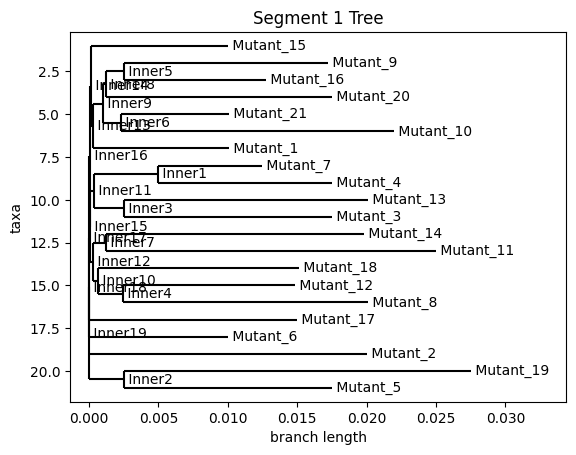

<Figure size 1000x500 with 0 Axes>

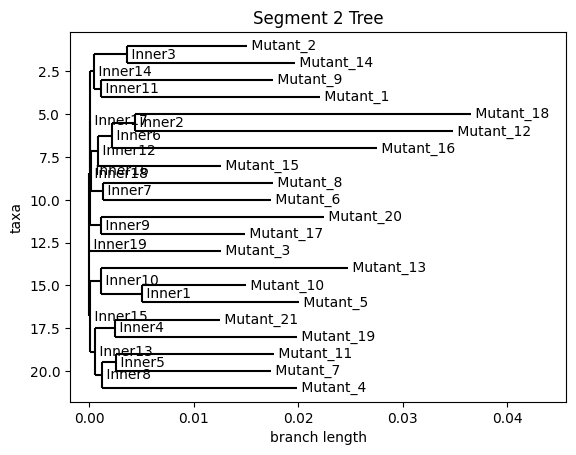

<Figure size 1000x500 with 0 Axes>

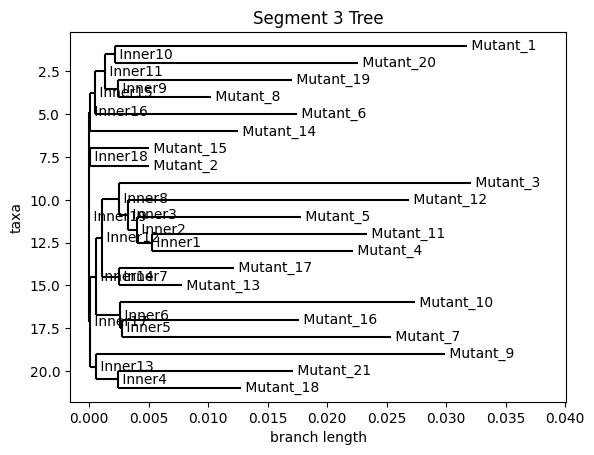

Robinson-Foulds distance between Segment 1 Tree and Segment 2 Tree: 36
Robinson-Foulds distance between Segment 1 Tree and Segment 3 Tree: 36
Robinson-Foulds distance between Segment 2 Tree and Segment 3 Tree: 36


In [2]:
# Install ClustalW
!apt-get install clustalw

import random
from Bio import Phylo
from Bio.Align.Applications import ClustalwCommandline
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceCalculator
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio import SeqIO
import matplotlib.pyplot as plt
from ete3 import Tree

# Function to generate random SNP mutants
def generate_snp_mutants(sequence, num_mutants, mutation_rate):
    mutants = []
    for _ in range(num_mutants):
        mutant = list(sequence)
        for i in range(len(mutant)):
            if random.random() < mutation_rate[i % len(mutation_rate)]:
                mutant[i] = random.choice(['A', 'T', 'G', 'C'])
        mutants.append(SeqRecord(Seq("".join(mutant)), id=f"Mutant_{_+1}", description=""))
    return mutants

# Function to create phylogenetic tree
def create_phylogenetic_tree(sequences, tree_label):
    # Write sequences to a file
    SeqIO.write(sequences, "alignment.fasta", "fasta")

    # Perform multiple sequence alignment using ClustalW
    clustalw_cline = ClustalwCommandline("clustalw", infile="alignment.fasta")
    stdout, stderr = clustalw_cline()

    # Read the alignment result
    alignment = AlignIO.read("alignment.aln", "clustal")

    # Calculate distance matrix
    calculator = DistanceCalculator('identity')
    dm = calculator.get_distance(alignment)

    # Construct the phylogenetic tree
    constructor = DistanceTreeConstructor()
    tree = constructor.nj(dm)

    # Save the tree to a file
    Phylo.write(tree, f"{tree_label}.xml", "phyloxml")

    # Plot the phylogenetic tree
    plt.figure(figsize=(10, 5))
    Phylo.draw(tree, do_show=False)
    plt.title(tree_label)
    plt.savefig(f"{tree_label}.png")
    plt.show()

    return tree

# Function to calculate Robinson-Foulds distance between two trees
def calculate_robinson_foulds(tree1, tree2):
    newick1 = tree1.format('newick')
    newick2 = tree2.format('newick')
    t1 = Tree(newick1, format=1)
    t2 = Tree(newick2, format=1)
    foo = t1.robinson_foulds(t2, unrooted_trees=True)
    rf_distance = foo[0]
    return rf_distance

# Main script
coding_sequence = "ATG" * 300  # Example coding sequence
non_coding_sequence = "CGT" * 100  # Example non-coding sequence
combined_sequence = coding_sequence + non_coding_sequence

# Generate 21 SNP mutants
mutation_rates = [0.01, 0.01, 0.03, 0.05]
mutants = generate_snp_mutants(combined_sequence, 21, mutation_rates)

# Split sequences into three segments
segment1 = [SeqRecord(Seq(str(seq.seq[:400])), id=seq.id, description="") for seq in mutants]
segment2 = [SeqRecord(Seq(str(seq.seq[400:800])), id=seq.id, description="") for seq in mutants]
segment3 = [SeqRecord(Seq(str(seq.seq[800:])), id=seq.id, description="") for seq in mutants]

# Create and plot phylogenetic trees for each segment
tree1 = create_phylogenetic_tree(segment1, "Segment 1 Tree")
tree2 = create_phylogenetic_tree(segment2, "Segment 2 Tree")
tree3 = create_phylogenetic_tree(segment3, "Segment 3 Tree")

# Calculate Robinson-Foulds distances between the trees
rf_distance_1_2 = calculate_robinson_foulds(tree1, tree2)
rf_distance_1_3 = calculate_robinson_foulds(tree1, tree3)
rf_distance_2_3 = calculate_robinson_foulds(tree2, tree3)

print(f"Robinson-Foulds distance between Segment 1 Tree and Segment 2 Tree: {rf_distance_1_2}")
print(f"Robinson-Foulds distance between Segment 1 Tree and Segment 3 Tree: {rf_distance_1_3}")
print(f"Robinson-Foulds distance between Segment 2 Tree and Segment 3 Tree: {rf_distance_2_3}")
